In [1]:
!nvidia-smi

Sat Mar 11 16:24:39 KST 2023

+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:14:00.0 Off |                    0 |
| N/A   32C    P0    24W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   32

In [2]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import nibabel as nib

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.7.1+cu110
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/aistore3/.conda/envs/snuimageseg/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.8.2+cu110
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.25.1
mlflow version: 2.1.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = "Pancreas-CT"
work_dir = "temp/230311"

In [4]:
images = sorted(
    glob.glob(os.path.join(data_dir, "data", "*.nii.gz")))
labels = sorted(
    glob.glob(os.path.join(data_dir, "TCIA_pancreas_labels-02-05-2017", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(images, labels)
]
print(len(data_dicts))

82


In [5]:
target_layers = list()

with open(os.path.join(data_dir, "230311/230311 target_layer.txt"), 'r') as f:
    for idx in range(len(data_dicts)):
        target_layers.append(int(f.readline().split()[1]))
        
print(target_layers)

[126, 89, 90, 96, 96, 96, 103, 104, 102, 90, 96, 107, 75, 132, 108, 181, 131, 101, 100, 102, 105, 185, 124, 168, 89, 140, 93, 106, 82, 182, 131, 127, 144, 73, 98, 69, 66, 115, 96, 117, 109, 142, 104, 273, 96, 80, 97, 88, 89, 141, 95, 112, 155, 80, 65, 111, 100, 128, 102, 124, 96, 134, 137, 113, 94, 85, 112, 93, 99, 100, 89, 78, 149, 99, 115, 96, 96, 136, 110, 89, 106, 118]


In [6]:
def nii_loader(filename) :
    nimg = nib.load( filename )
    return nimg.get_fdata() , nimg.affine, nimg.header 

def visualize(dataset, target_layers, idx=0):
    image = dataset[idx]['image']
    label = dataset[idx]['label']
    target_layer = target_layers[idx]

    image_data, image_affine, image_header = nii_loader(image)
    label_data, label_affine, label_header = nii_loader(label)

    print(image_data.shape, label_data.shape)
    target_image = image_data[:,:,target_layer]
    target_label = label_data[:,:,target_layer]

    fig, (ax1, ax2) = plt.subplots(1, 2 ,  figsize=(12,8))

    ax1.imshow(target_image, cmap='gray' )
    ax1.set_title(f'Layer {target_layer}')
    ax2.imshow(target_label )
    ax2.set_title('GT segmentation')
    plt.show()

(512, 512, 205) (512, 512, 205)


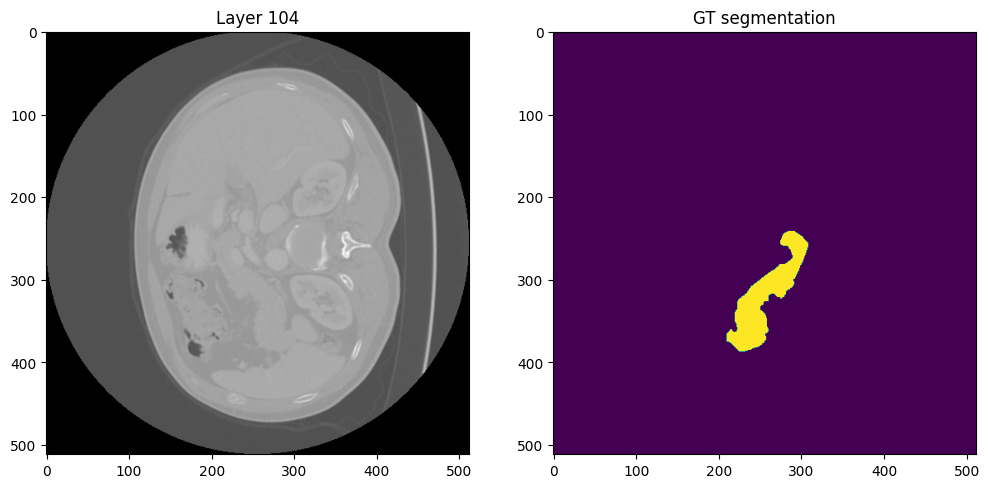

In [7]:
visualize(data_dicts, target_layers, idx=7)

In [8]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    RandAffined,
)

In [9]:
from monai.transforms import Compose

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

image shape: torch.Size([293, 202, 120]), label shape: torch.Size([293, 202, 120])


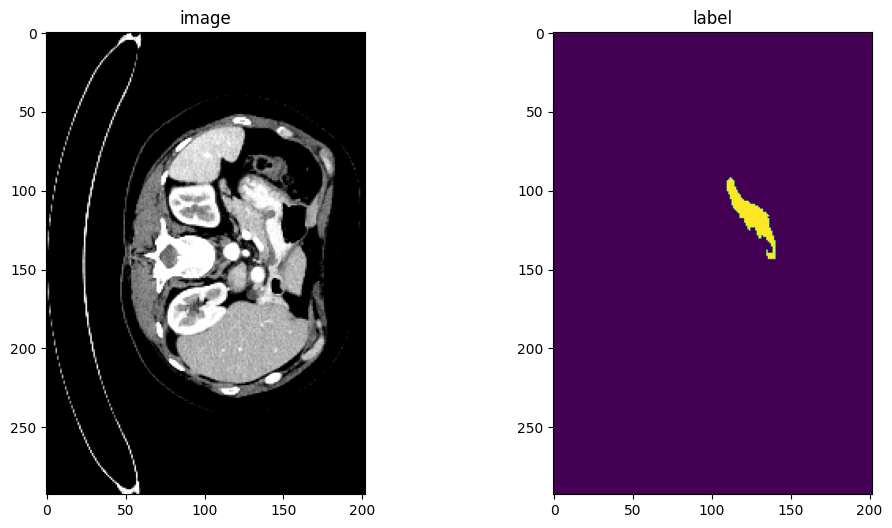

In [10]:
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.utils import first, set_determinism

check_ds = Dataset(data=data_dicts, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
target_layer = int(image.shape[2]/2)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, target_layer], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, target_layer])
plt.show()

In [11]:
from monai.data import CacheDataset, DataLoader
from monai.data.utils import pad_list_data_collate

full_ds = CacheDataset(data=data_dicts, transform=val_transforms, cache_rate=1.0, num_workers=4, progress=True)
full_loader = DataLoader(full_ds, batch_size=1, shuffle=True, num_workers=10, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████████████████████| 82/82 [02:01<00:00,  1.48s/it]


In [12]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm


device = torch.device("cuda:0")
out_channels = 2
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=out_channels,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [13]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [14]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [15]:
from monai.data.utils import decollate_batch
from monai.transforms import EnsureType, AsDiscrete
from monai.inferers import sliding_window_inference

max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=out_channels)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=out_channels)])

roi_size = (160, 160, 160)
sw_batch_size = 4

In [16]:
model.load_state_dict(torch.load(os.path.join(work_dir, "spleen_unet_model_best.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [28]:
a_outputs = None

with torch.no_grad():
    for val_data in full_loader:
        a = val_data
        break
        
    a_outputs = sliding_window_inference(a["image"].to(device), roi_size, sw_batch_size, model)

In [36]:
def get_target_layer(val_outputs):
    layers = torch.argmax(val_outputs, dim=1).detach().cpu()[0]
    
    max_area = 0
    max_layer = 0
    
    for current_layer in range(layers.shape[2]):
        organ_area = sum(sum(layers[:,:,current_layer]))
        if organ_area > max_area:
            max_area = organ_area
            max_layer = current_layer
            
    return layers[:,:,max_layer]

In [44]:
def inference_segment(val_loader, model, num_data=2):
    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            val_outputs = sliding_window_inference(
                val_data["image"].to(device), roi_size, sw_batch_size, model
            )
            output_image = torch.argmax(val_outputs, dim=1).detach().cpu() 
            target_layer = int(val_data["image"].shape[4]/2)
            # plot the slice [:, :, target_layer]
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            plt.imshow(val_data["image"][0, 0, :, :, target_layer], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            plt.imshow(val_data["label"][0, 0, :, :, target_layer])
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            plt.imshow(get_target_layer(val_outputs))
            plt.show()
            if i == num_data:
                break                
    
def inference_segment_best(work_dir, val_loader, model, prefix, num_data=2):
    import torch
    model.load_state_dict(torch.load(os.path.join(work_dir, "spleen_{}_model_best.pth".format(prefix) )))
    model.eval()
    inference_segment(val_loader, model, num_data)

def inference_segment_epoch(work_dir, val_loader, model, prefix, epoch=30, num_data=2):
    import torch
    model.load_state_dict(torch.load(os.path.join(work_dir, "spleen_{}_model_{:04d}.pth".format(prefix, epoch))))
    model.eval()
    inference_segment(val_loader, model, num_data)

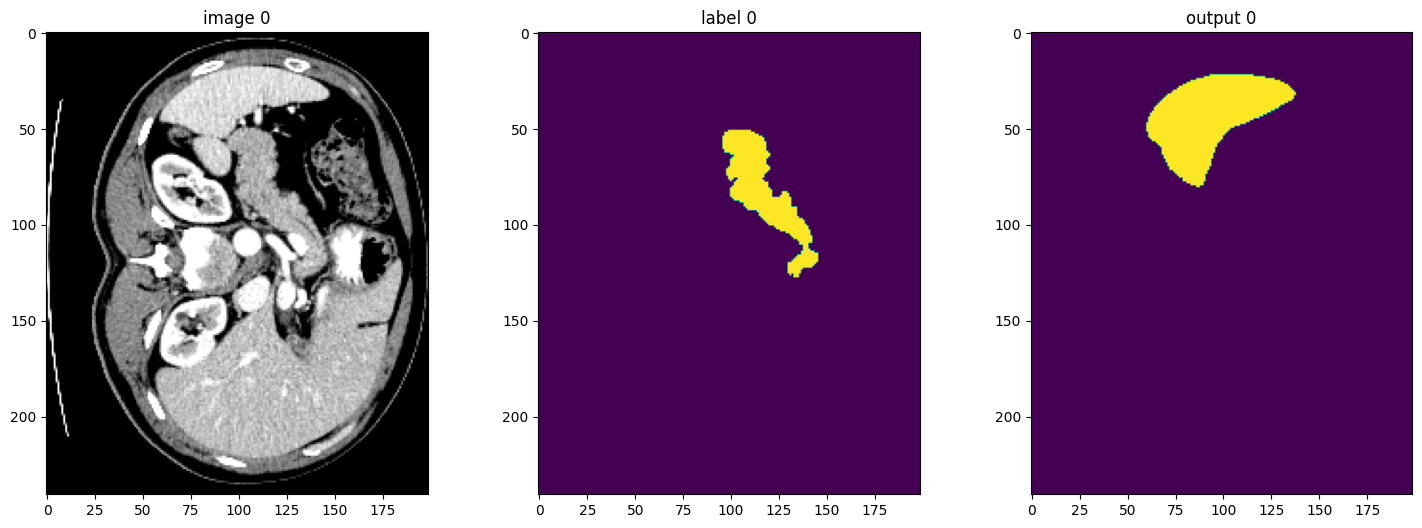

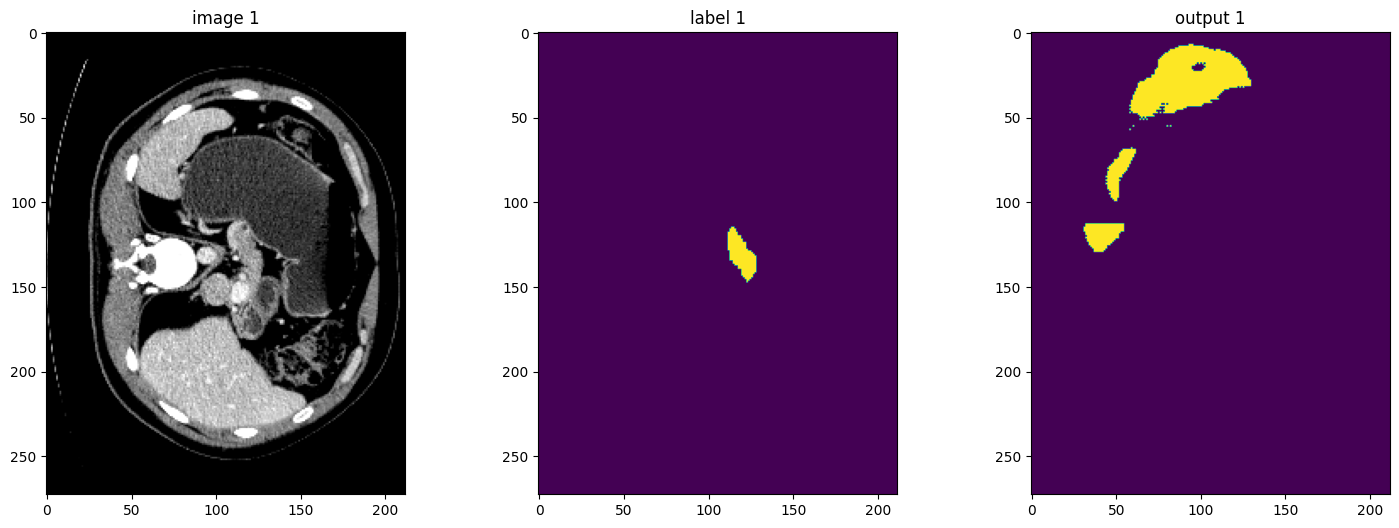

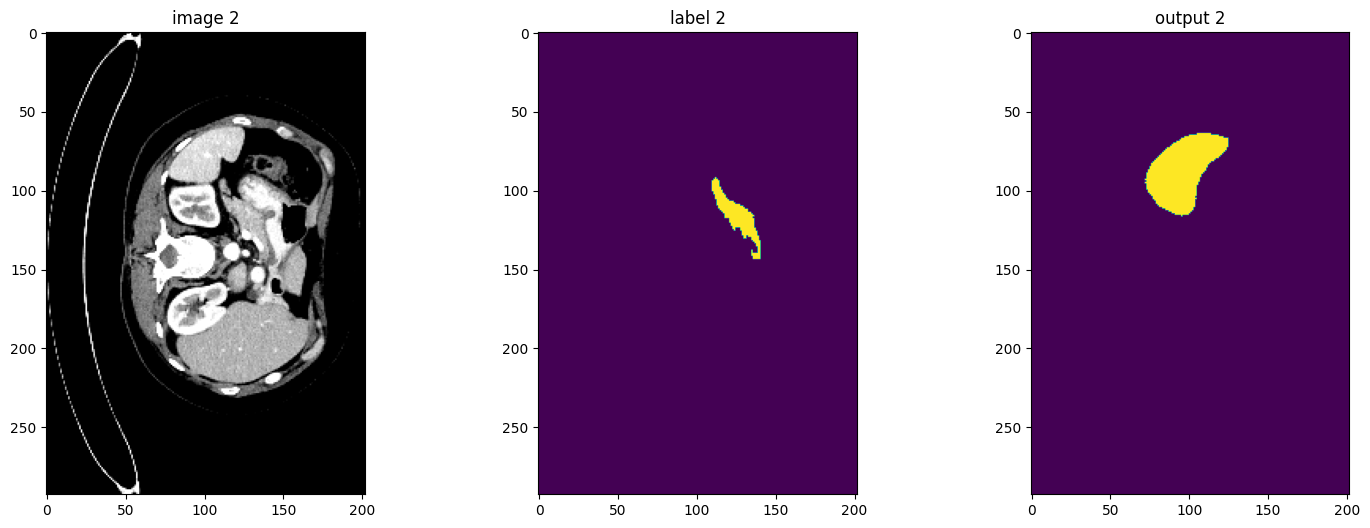

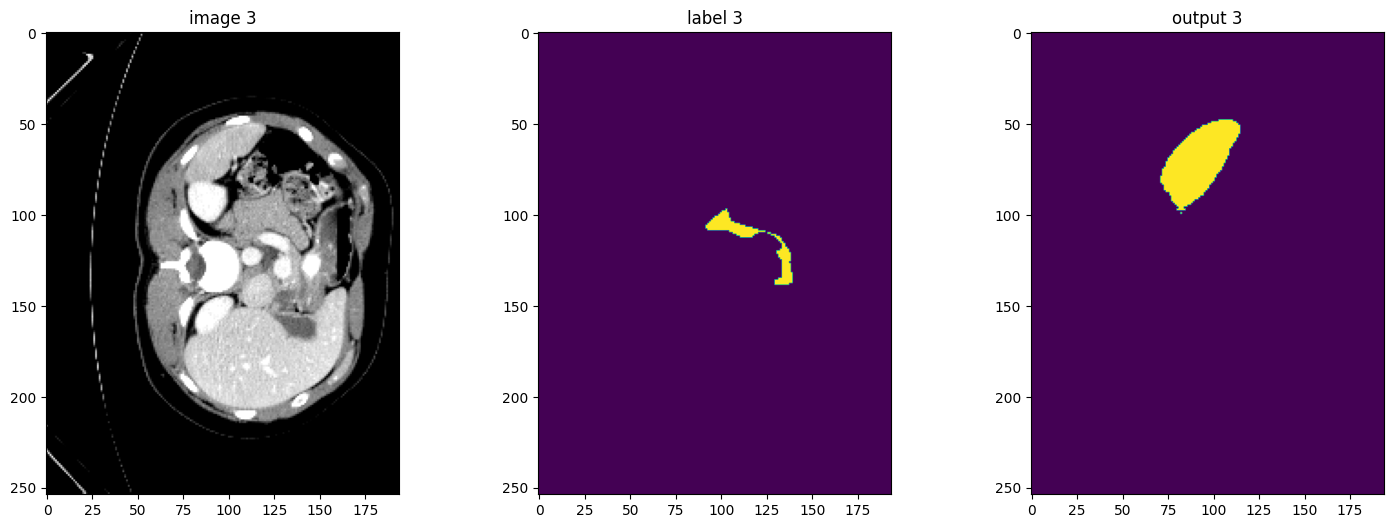

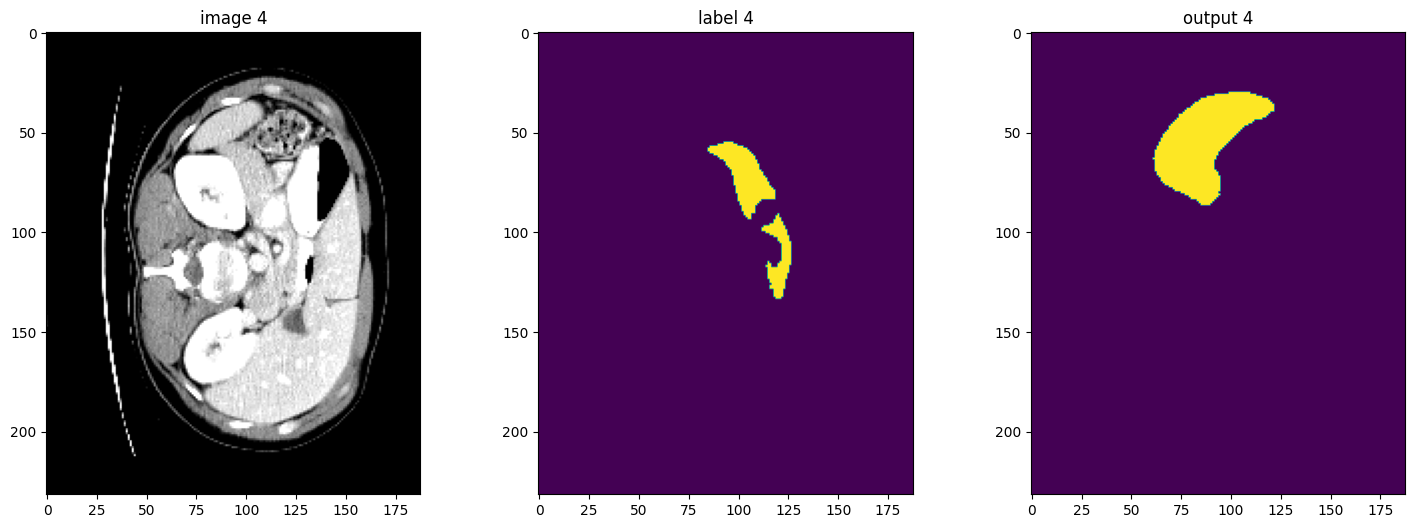

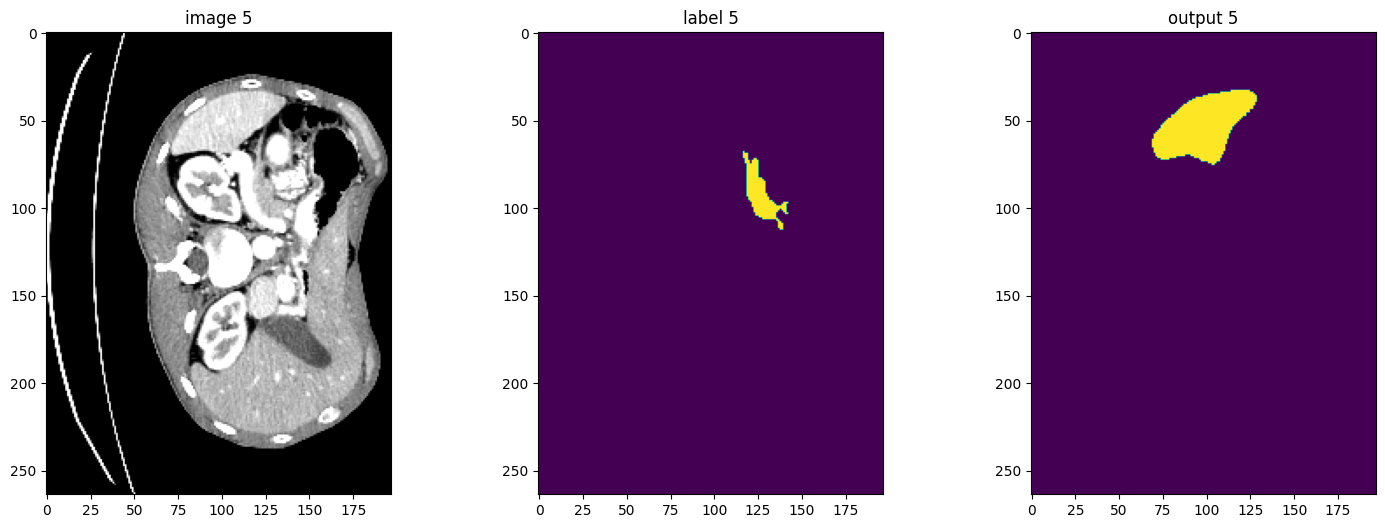

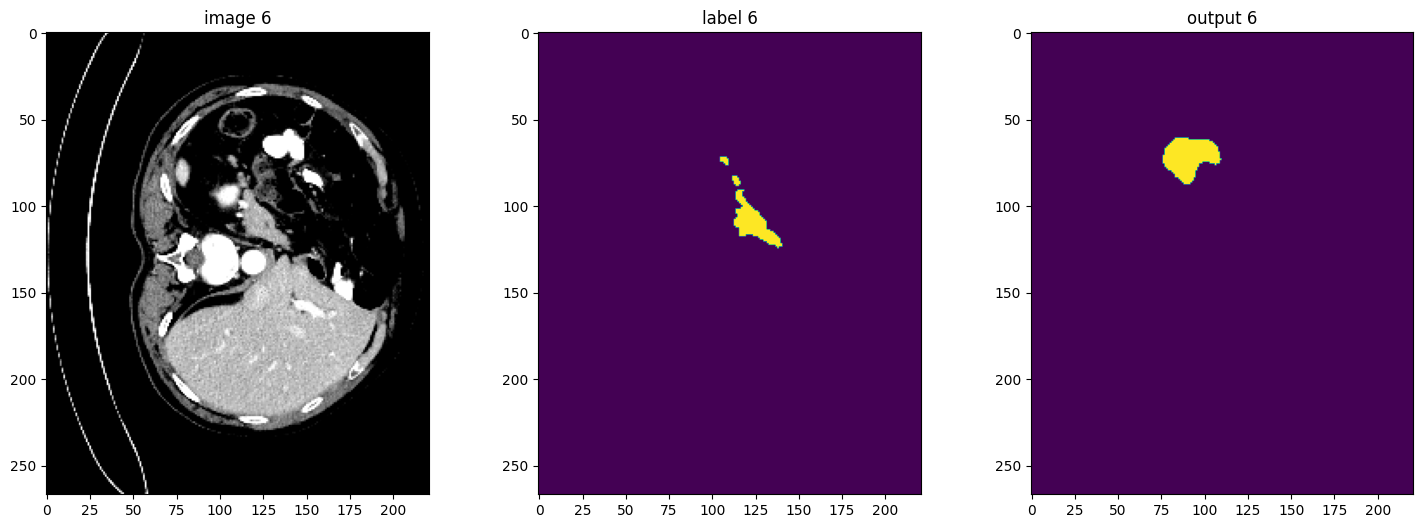

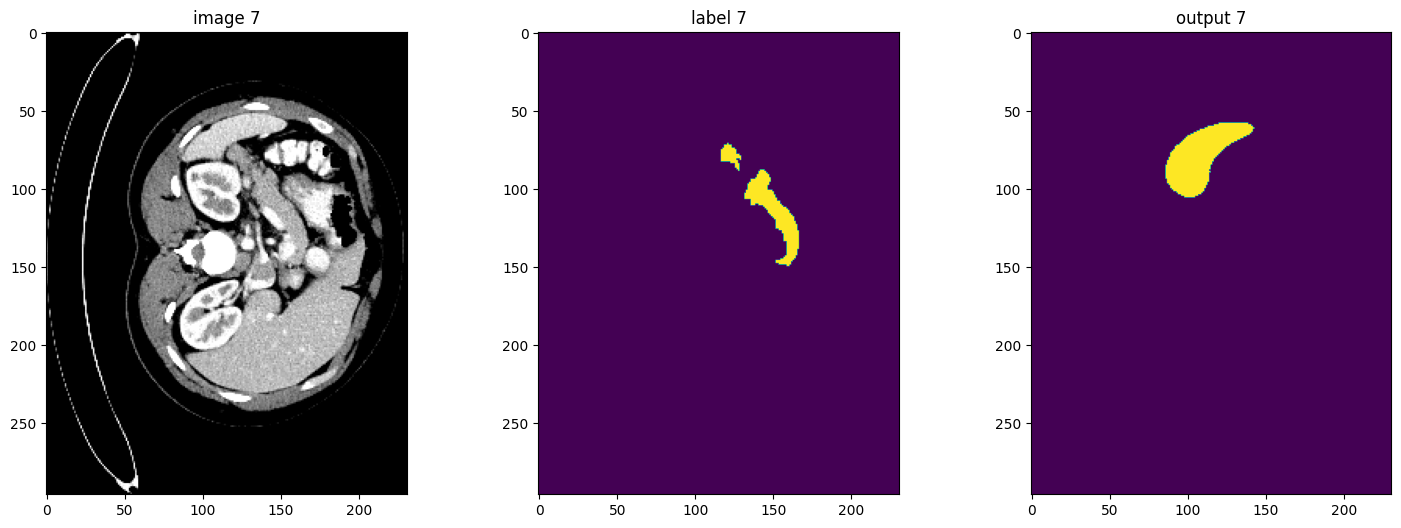

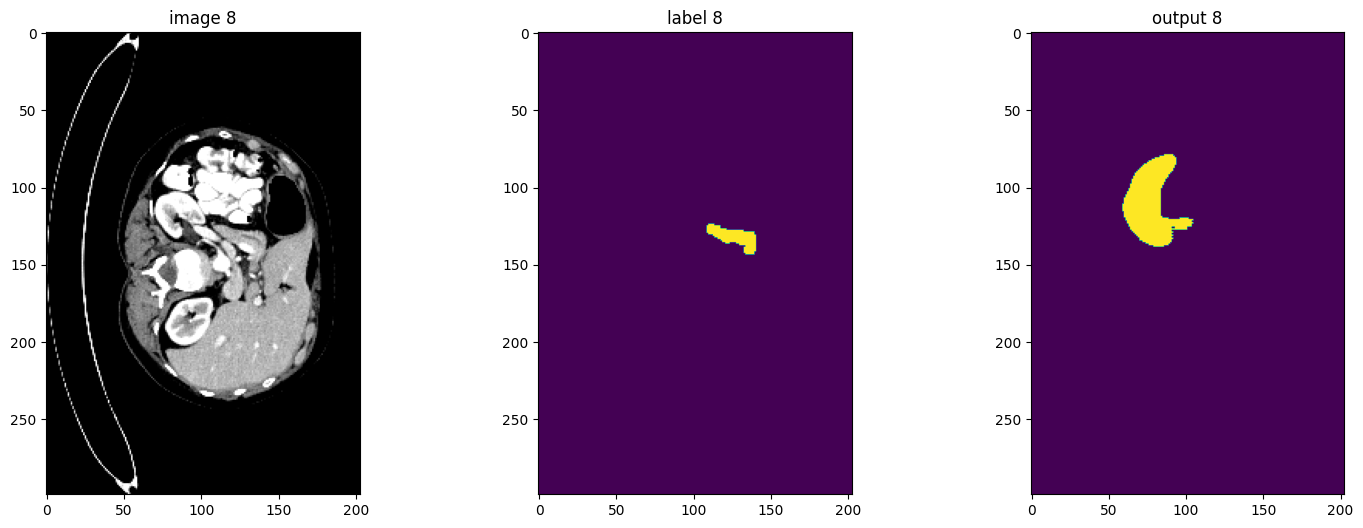

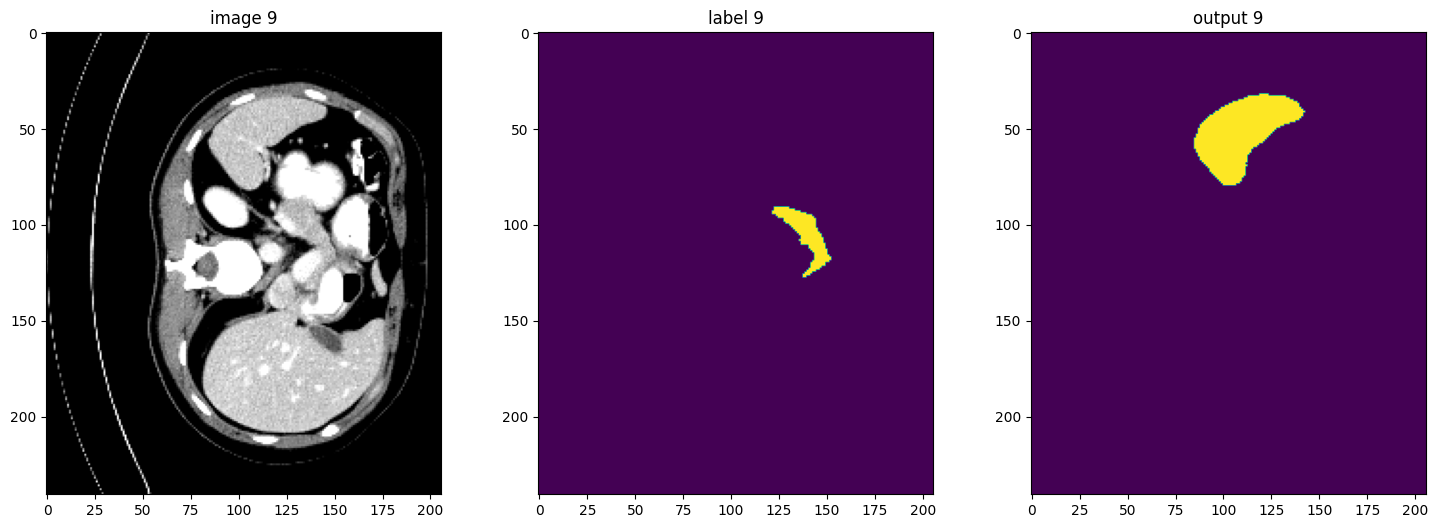

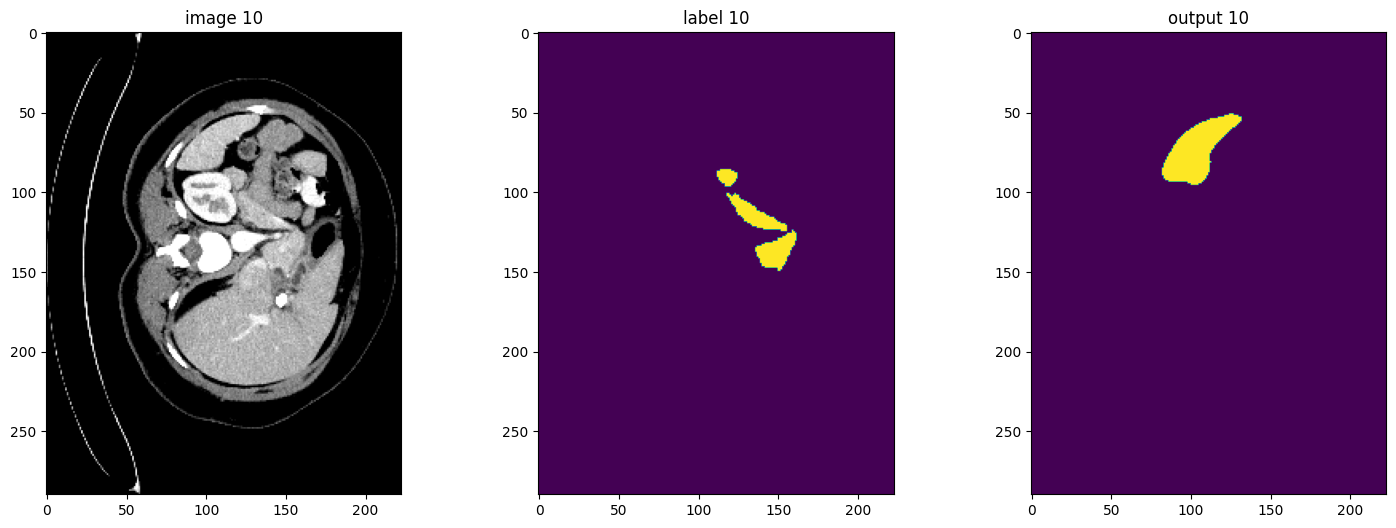

In [46]:
inference_segment_best(work_dir, full_loader, model, 'unet', num_data=10)